### Import & load data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [ ]:
!head airline_passengers.csv

"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136


frequency: MS



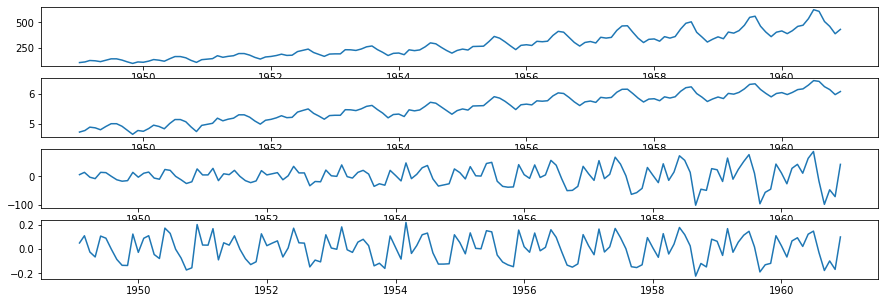

In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
print(f'frequency: {df.index.inferred_freq}\n')

fig, ax = plt.subplots(nrows=4, figsize=(15,5));
ax[0].plot(df);
ax[1].plot(df.apply(np.log));
ax[2].plot(df.diff());
ax[3].plot(df.apply(np.log).diff());

### Define plot_forecast()

We fit two different models:

1.   Single-output model: predict next month based on past 12 months
2.   Multi-output model: predict next 12 months based on past 12 months

We then compare a multi-step forecast (done with the single-output model by using past predictions as input), with a multi-output forecast from the multi-output model. We try to forecast the last 12 months, based on the previous 12 months.

Note that a naive scoring for the single-output model would be on the one-step forecast, that simply predicts one month ahead. This is only interesting if we really just want to predict one step ahead with our model. It would then make no sense to compare this model with the multi-output one.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.base import clone, RegressorMixin  # clone to train two models
from sklearn.multioutput import MultiOutputRegressor  # to make SVR multi-output
from sklearn.metrics import mean_absolute_percentage_error, r2_score

_tr_dict = {
    'id': {'direct': lambda x: x, 'inverse': lambda x: x},
    'log': {'direct': np.log, 'inverse': np.exp}
}

def plot_forecast(df:pd.core.frame.DataFrame, model:RegressorMixin, T=12,
                  diff=False, transform='id',
                  ax:Axes=None) -> Axes:
  
  series = df.to_numpy().reshape(-1)
  transform = _tr_dict[transform]

  # Apply transform and diff, then apply a sliding window
  series_trans = transform['direct'](series)
  if diff:
    series_diff = np.diff(series_trans)
    series_slide = sliding_window_view(series_diff, T)
  else:
    series_slide = sliding_window_view(series_trans, T)

  # Autoregression: define X and Y from data, all of lenght T.
  # Note that Y[i] = X[i+T]. They must not overlap!
  X = series_slide[:-T]
  Y = series_slide[T:]

  # We keep the last period for test.
  # To achieve complete separation of train and test, we need to remove the last
  # T sliding windows from the train set, since they all have data in common
  # with the test set.
  X_train, X_test, Y_train, Y_test = X[:-T], X[-1:], Y[:-T], Y[-1:]
  y_train, y_test = Y_train[:,0], Y_test[:, 0] # y for the single-output model

  # Single-output model
  model_s = clone(model)
  model_s.fit(X_train, y_train)
  # One could test the single-output model on single-step predictions, but
  # it does not reveal much on its predictive power with respect to the multi-output model.
  #print(f'train score (s): {model_s.score(X_train, y_train):.4f}')
  #print(f'train mape (s): {mean_absolute_percentage_error(model_s.predict(X_train), y_train):.4f}')
  # Multi-step forecast
  X_s = X_test
  Y_s = []
  for t in range(T):
    y_s = model_s.predict(X_s)[0]
    Y_s.append(y_s)
    X_s = np.roll(X_s, -1)
    X_s[0,-1] = y_s
  Y_s = np.array(Y_s).T.reshape(-1)

  # Multi-output model
  model_m = clone(model)
  try:
    model_m.fit(X_train, Y_train)
  except ValueError as e:
    model_m = MultiOutputRegressor(model_m)
    model_m.fit(X_train, Y_train)
  # We prefer to test the model on the actual prediction that we need,
  # after undoing any transform and diff.
  #print(f'train score (m): {model_m.score(X_train, Y_train):.4f}')
  #print(f'train mape (m): {mean_absolute_percentage_error(model_m.predict(X_train), Y_train):.4f}')
  # Multi-output forecast
  Y_m = model_m.predict(X_test).reshape(-1)
  
  # Test data
  Y_test = Y_test.reshape(-1)

  # Undo diff
  if diff:
    x_0 = series_trans[[len(X)+T-1]]  # last train data before differencing
    Y_s = x_0 + np.cumsum(Y_s)
    Y_m = x_0 + np.cumsum(Y_m)
    Y_test = x_0 + np.cumsum(Y_test)
  # Undo transform
  Y_s = transform['inverse'](Y_s)
  Y_m = transform['inverse'](Y_m)
  Y_test = transform['inverse'](Y_test)

  # Compare forecasts from the two models. For the single-output model, we need to 
  # calculate the metrics on the multi-step forecast.
  print(f'R2 multi-step  : {r2_score(Y_s, Y_test):.3f}')
  print(f'R2 multi-output: {r2_score(Y_m, Y_test):.3f}')
  print(f'mape multi-step  : {mean_absolute_percentage_error(Y_s, Y_test):.3f}')
  print(f'mape multi-output: {mean_absolute_percentage_error(Y_m, Y_test):.3f}')
  print()

  # Plot data and forecasts
  if not ax: fig, ax = plt.subplots(figsize=(15,5))
  N = len(series)
  start = N - 2*T  # plot last two periods only
  #ax.plot(list(range(start,N-T+1)), series[start:N-T+1], label='train');
  #ax.plot(list(range(start+T,N)), Y_test, label='test');
  ax.plot(list(range(start,N)), series[start:], label='data')
  ax.plot(list(range(start+T,N)), Y_s, label='multi-step')
  ax.plot(list(range(start+T,N)), Y_m, label='multi-output')
  ax.axvline(x=N-T, color='black', ls='--', lw=.5)
  ax.legend()
  return ax

### Stationarity test

From the ADF test alone, it seems that it would make sense to take the first differences, since the dataset is much more stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

print(f'ADF(df): {adfuller(df)[1]:.4f}')
print(f'ADF(np.log(df)): {adfuller(np.log(df))[1]:.4f}')
print(f'ADF(df.diff()): {adfuller(df.diff().dropna())[1]:.4f}')

ADF(df): 0.9919
ADF(np.log(df)): 0.4224
ADF(df.diff()): 0.0542


### Linear Regression

R2 multi-step  : 0.922
R2 multi-output: 0.946
mape multi-step  : 0.035
mape multi-output: 0.033

R2 multi-step  : 0.945
R2 multi-output: 0.947
mape multi-step  : 0.027
mape multi-output: 0.028

R2 multi-step  : 0.910
R2 multi-output: 0.929
mape multi-step  : 0.035
mape multi-output: 0.034

R2 multi-step  : 0.927
R2 multi-output: 0.923
mape multi-step  : 0.034
mape multi-output: 0.034



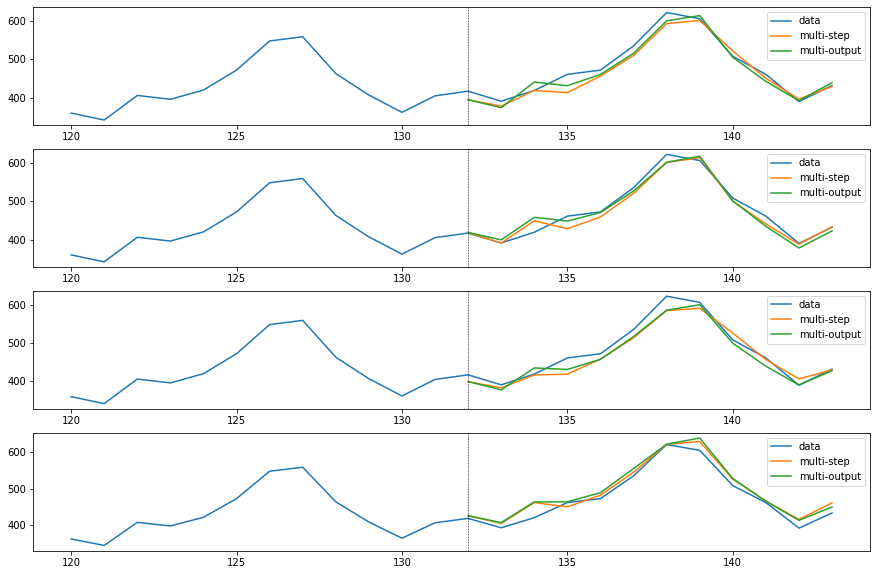

In [ ]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(nrows=4, figsize=(15,10))
plot_forecast(df, LinearRegression(), ax=ax[0]);
plot_forecast(df, LinearRegression(), ax=ax[1], diff=True);  # best one
plot_forecast(df, LinearRegression(), ax=ax[2], transform='log');
plot_forecast(df, LinearRegression(), ax=ax[3], transform='log', diff=True);

### SVR with linear kernel

R2 multi-step  : 0.917
R2 multi-output: 0.920
mape multi-step  : 0.036
mape multi-output: 0.033

R2 multi-step  : 0.905
R2 multi-output: 0.927
mape multi-step  : 0.036
mape multi-output: 0.037

R2 multi-step  : 0.921
R2 multi-output: 0.925
mape multi-step  : 0.034
mape multi-output: 0.034



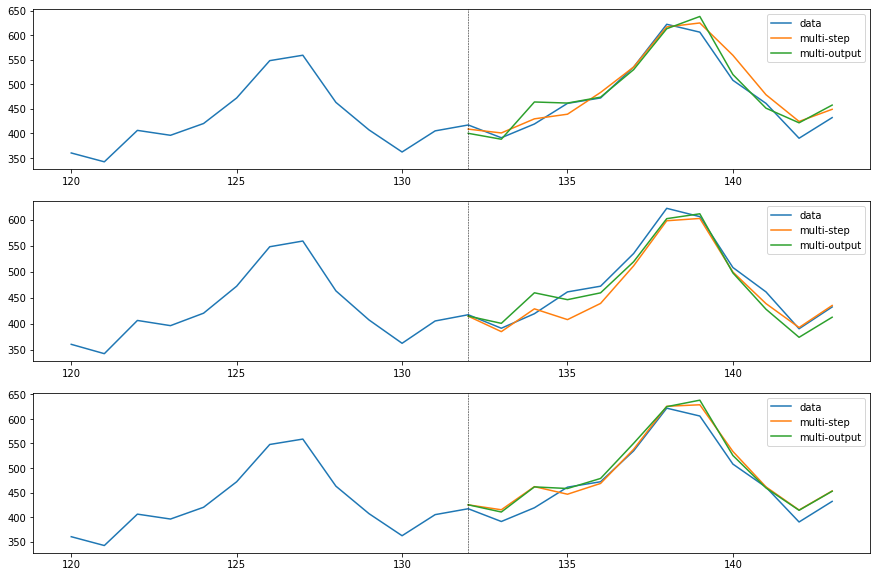

In [ ]:
from sklearn.svm import LinearSVR

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)  # we hide the liblinear convergence warnings

fig, ax = plt.subplots(nrows=3, figsize=(15,10))
plot_forecast(df, LinearSVR(max_iter=100000), ax=ax[0]);  # many iterations required for convergence, without diff
plot_forecast(df, LinearSVR(max_iter=10000), ax=ax[1], diff=True);
plot_forecast(df, LinearSVR(max_iter=10000), ax=ax[2], diff=True, transform='log');

### SVR with rbf kernel

R2 multi-step  : -9120.787
R2 multi-output: -539.744
mape multi-step  : 0.802
mape multi-output: 0.695

R2 multi-step  : -105.398
R2 multi-output: -52.281
mape multi-step  : 0.147
mape multi-output: 0.144

R2 multi-step  : -4.961
R2 multi-output: -3.937
mape multi-step  : 0.336
mape multi-output: 0.263

R2 multi-step  : 0.046
R2 multi-output: 0.272
mape multi-step  : 0.068
mape multi-output: 0.064



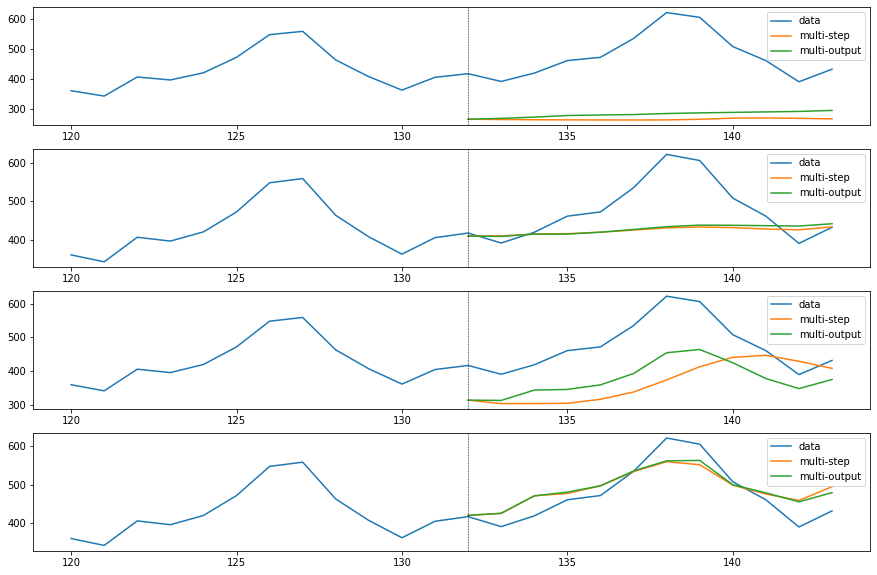

In [ ]:
from sklearn.svm import SVR

fig, ax = plt.subplots(nrows=4, figsize=(15,10))
plot_forecast(df, SVR(), ax=ax[0]);  # poor performance
plot_forecast(df, SVR(), ax=ax[1], diff=True);  # poor performance
plot_forecast(df, SVR(), ax=ax[2], transform='log');  # poor performance
plot_forecast(df, SVR(), ax=ax[3], transform='log', diff=True);  # better, but still poor performance

### Random Forest

R2 multi-step  : -1.338
R2 multi-output: -7.577
mape multi-step  : 0.100
mape multi-output: 0.179

R2 multi-step  : 0.855
R2 multi-output: 0.675
mape multi-step  : 0.039
mape multi-output: 0.046

R2 multi-step  : 0.663
R2 multi-output: 0.913
mape multi-step  : 0.072
mape multi-output: 0.031



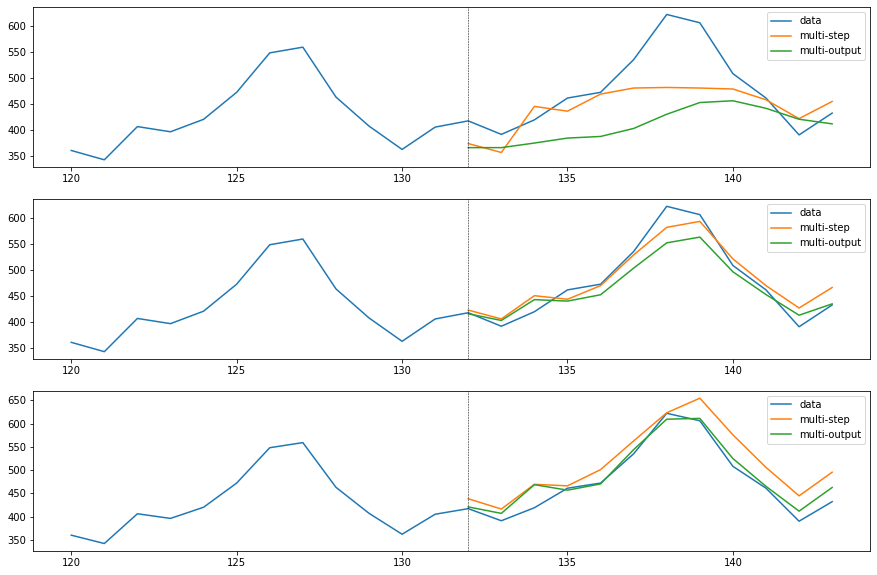

In [ ]:
from sklearn.ensemble import RandomForestRegressor

fig, ax = plt.subplots(nrows=3, figsize=(15,10))
plot_forecast(df, RandomForestRegressor(), ax=ax[0]);  # poor results without diff
plot_forecast(df, RandomForestRegressor(), ax=ax[1], diff=True);  # second best one (with multi-step)
plot_forecast(df, RandomForestRegressor(), ax=ax[2], transform='log', diff=True);  # best one (with multi-output)